In [110]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

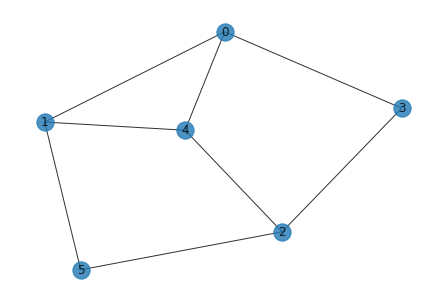

In [119]:
edges = [(0,1), (0,4), (0,3), (1,4), (1,5), (2,3), (2,4), (2,5)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

In [112]:
def min_vertex_cover(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [113]:
 def create_qaoa_circ(G, theta):   
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//((nqubits*2)+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * gamma[irep,k], i)
            k+=1
        
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            qc.barrier()
            k+=1
        
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        
    qc.measure_all()
    return qc

In [114]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = min_vertex_cover(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [115]:
def get_expectation(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

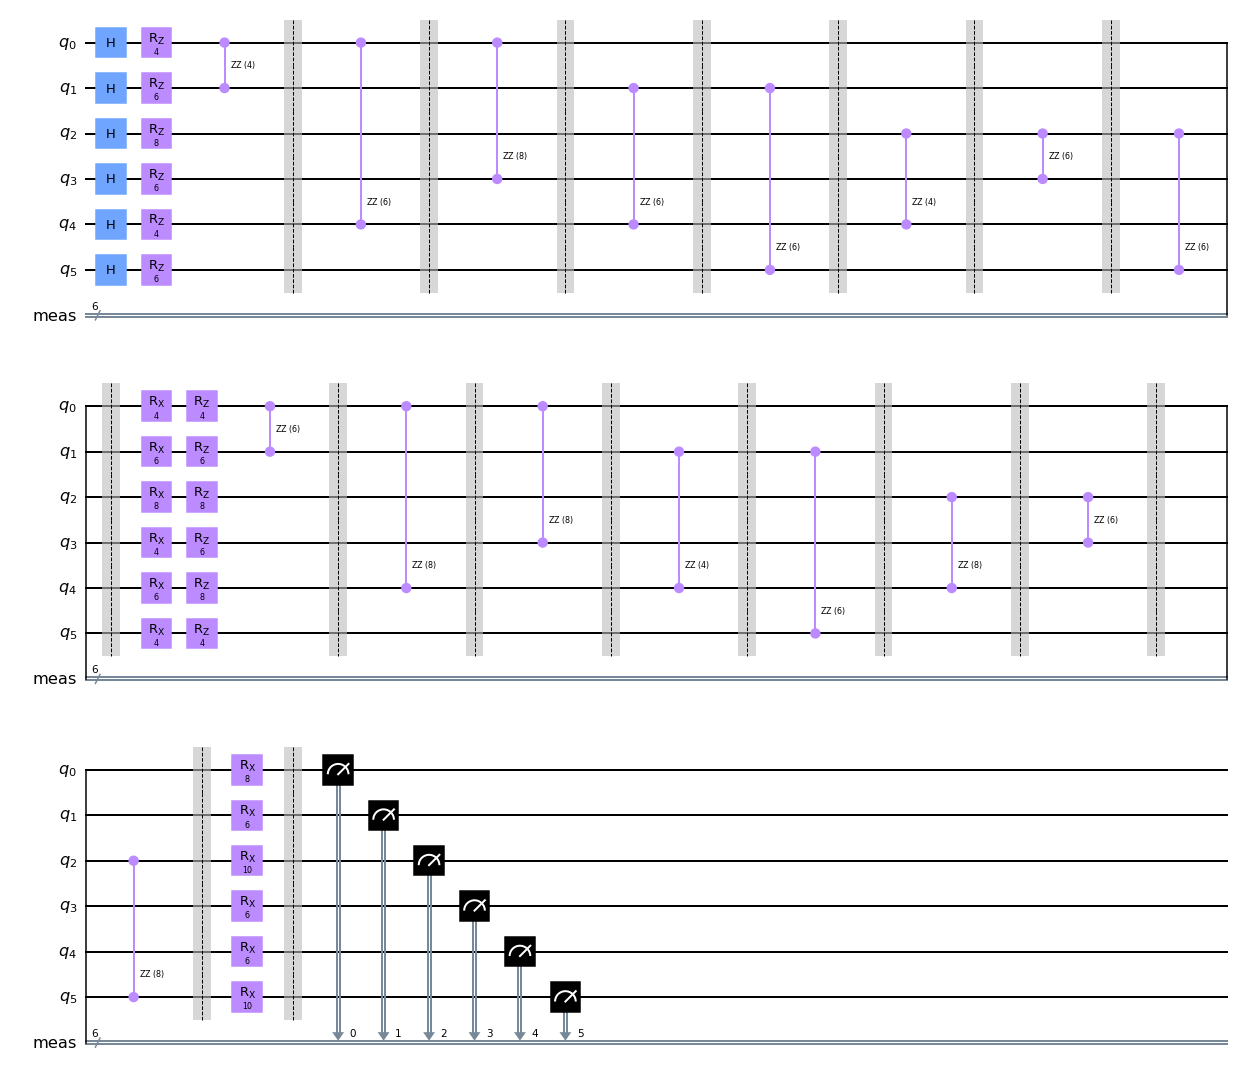

In [124]:
# Adding Parameters
beta = np.array([[2,3,4,2,3,2], [4,3,5,3,3,5]]) #Edit as per the number of qubits
gamma = np.array([[2,3,4,3,2,3,2,3,4,3,3,2,3,3],[2,3,4,3,4,2,3,4,4,2,3,4,3,4]]) #Edit as per the number of (qubits + edges)
theta = np.concatenate((beta.flatten(), gamma.flatten()))

qc = create_qaoa_circ(G, theta)
qc.draw()

In [125]:
from scipy.optimize import minimize
expectation = get_expectation(G)
res = minimize(expectation, theta, method='COBYLA')
res

     fun: -6.962890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 622
  status: 1
 success: True
       x: array([1.76423415, 3.08262489, 5.50451146, 2.78303294, 3.26976036,
       2.08197027, 3.9965211 , 2.34125225, 4.71924623, 4.07118117,
       3.76659751, 5.33580083, 1.85634414, 3.15582894, 3.92434639,
       2.66085126, 1.98505935, 2.94044605, 1.59259113, 2.90534691,
       3.62470812, 2.66572738, 3.18004607, 3.16798516, 3.13966186,
       3.16018294, 2.32897836, 2.40888589, 4.10550524, 3.15779383,
       4.38021096, 1.92172705, 3.22756733, 4.39863946, 3.65186831,
       2.04876467, 3.1477953 , 4.0714716 , 3.41419207, 4.37688956])

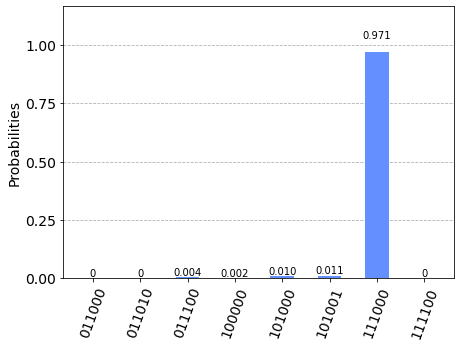

In [126]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)